# Download and Extract the Data
- Download the zipped file using CurlWidget chrome extention.
- Extracting content from the zipped file.

In [2]:
!wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en;q=0.9,hi-IN;q=0.8,hi;q=0.7,ta-IN;q=0.6,ta;q=0.5,en-GB;q=0.4,en-US;q=0.3" --header="Cookie: __utmz=3028652.1624856291.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utma=3028652.1813042570.1624856084.1624856291.1624950891.3" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'

--2021-07-10 06:20:54--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [39]:
import os
from zipfile import ZipFile 

with ZipFile("ita-eng.zip", 'r') as zip: 
    zip.extractall() 
del zip
lines = open(os.getcwd() + '/ita.txt', encoding='utf-8').read().split('\n')
print(f'No of lines: {len(lines)}')

No of lines: 350361


# Configuration

In [40]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 50000  # Number of samples to train on.

# Data Preprocessing
- Formulating text into a proper sentences.
- Normalizing strings and removing unwanted characters.
- Tokenizing characters.

In [42]:
print(lines[0])
print('-'*100) 
print(lines[800])
print('-'*100) 
print(lines[3500])
print('-'*100) 
print(lines[6000])
print('-'*100) 

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)
----------------------------------------------------------------------------------------------------
I talked.	Parlai.	CC-BY 2.0 (France) Attribution: tatoeba.org #5828639 (CK) & #6104647 (Guybrush88)
----------------------------------------------------------------------------------------------------
Keep still.	Resta ferma.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111636 (CK) & #4581663 (Guybrush88)
----------------------------------------------------------------------------------------------------
Now go home.	Ora vai a casa.	CC-BY 2.0 (France) Attribution: tatoeba.org #2249679 (CK) & #3512696 (Guybrush88)
----------------------------------------------------------------------------------------------------


In [46]:
import re

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for line in lines[:num_samples]:
    input_text, target_text = line.split("\t")[0], line.split("\t")[1]

    # Removing unwanted characters like punctuation marks
    input_text = re.sub(r'[^\w\s]', '', input_text)
    # Removing digits
    input_text = re.sub(" \d+", " ", input_text)
    # Remoing extra white spaces
    input_text = re.sub(' +', ' ', input_text)
    # Converting to lower case
    input_text = input_text.lower()

    target_text = re.sub(r'[^\w\s]', '', target_text)
    target_text = re.sub(" \d+", " ", target_text)
    target_text = re.sub(' +', ' ', target_text)
    target_text = target_text.lower()
    # '\t' and '\n' characters are added to signify start end of the italian sentences
    target_text = "\t" + target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)

    # Storing each character in a set
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [47]:
# Cleaned sentences
print(input_texts[0],'-->',target_texts[0].replace('\t', '').replace('\n', ''))
print(input_texts[800],'-->',target_texts[800].replace('\t', '').replace('\n', ''))
print(input_texts[3500],'-->',target_texts[3500].replace('\t', '').replace('\n', ''))
print(input_texts[6000],'-->',target_texts[6000].replace('\t', '').replace('\n', ''))
print(input_texts[8500],'-->',target_texts[8500].replace('\t', '').replace('\n', ''))
print(input_texts[45000],'-->',target_texts[45000].replace('\t', '').replace('\n', ''))

hi --> ciao
i talked --> parlai
keep still --> resta ferma
now go home --> ora vai a casa
i was asleep --> stavo dormendo
can we talk alone --> possiamo parlare da soli


In [48]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Input characters (English)", input_characters)
print("Target characters (Italian)", target_characters)
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Input characters (English) [' ', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é']
Target characters (Italian) ['\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'à', 'è', 'é', 'ì', 'ò', 'ù', 'ō']
Number of samples: 50000
Number of unique input tokens: 29
Number of unique output tokens: 37
Max sequence length for inputs: 17
Max sequence length for outputs: 102


In [49]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

print("Input token index: ", input_token_index)
print("Target token index: ", target_token_index)

Input token index:  {' ': 0, '5': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'é': 28}
Target token index:  {'\t': 0, '\n': 1, ' ': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '\xa0': 29, 'à': 30, 'è': 31, 'é': 32, 'ì': 33, 'ò': 34, 'ù': 35, 'ō': 36}


In [50]:
import numpy as np
encoder_input_data = np.zeros(shape=(num_samples, max_encoder_seq_length, num_encoder_tokens), dtype="float32")  # 10000 matrices of size 12 X 27
decoder_input_data = np.zeros(shape=(num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32")  # 10000 matrices of size 44 X 35
decoder_target_data = np.zeros(shape=(num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32") # 10000 matrices of size 44 X 35

In [51]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):    # Traversing over each sentence
    for t, char in enumerate(input_text):                                         # Traversing over each character in a sentence
        encoder_input_data[i, t, input_token_index[char]] = 1.0                   # Based on input token dictionary it will assign the value 1 in the respective index
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0                  # For remaining rows, value 1 will be assined corresponding to blank value/empty string
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0                  # Based on input token dictionary it will assign the value 1 in the respective index
        if t > 0:                                                                 # decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0         
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0                 # For remaining rows, value 1 will be assined corresponding to blank value/empty string
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0                     # For remaining rows, value 1 will be assined corresponding to blank value/empty string

In [53]:
import tensorflow as tf

# Define an input sequence and process it
encoder_inputs = tf.keras.Input(shape=(None, num_encoder_tokens))
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
decoder_inputs = tf.keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Train the model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
          x=[encoder_input_data, decoder_input_data],
          y=decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          )

Epoch 1/100
625/625 [==============================] - 17s 18ms/step - loss: 0.4255 - accuracy: 0.8784 - val_loss: 0.3688 - val_accuracy: 0.8845
Epoch 2/100
625/625 [==============================] - 11s 17ms/step - loss: 0.2720 - accuracy: 0.9145 - val_loss: 0.2961 - val_accuracy: 0.9065
Epoch 3/100
625/625 [==============================] - 11s 17ms/step - loss: 0.2250 - accuracy: 0.9295 - val_loss: 0.2646 - val_accuracy: 0.9170
Epoch 4/100
625/625 [==============================] - 11s 17ms/step - loss: 0.1966 - accuracy: 0.9383 - val_loss: 0.2422 - val_accuracy: 0.9247
Epoch 5/100
625/625 [==============================] - 10s 17ms/step - loss: 0.1771 - accuracy: 0.9442 - val_loss: 0.2302 - val_accuracy: 0.9282
Epoch 6/100
625/625 [==============================] - 11s 17ms/step - loss: 0.1623 - accuracy: 0.9487 - val_loss: 0.2208 - val_accuracy: 0.9315
Epoch 7/100
625/625 [==============================] - 11s 17ms/step - loss: 0.1506 - accuracy: 0.9522 - val_loss: 0.2149 - val_ac

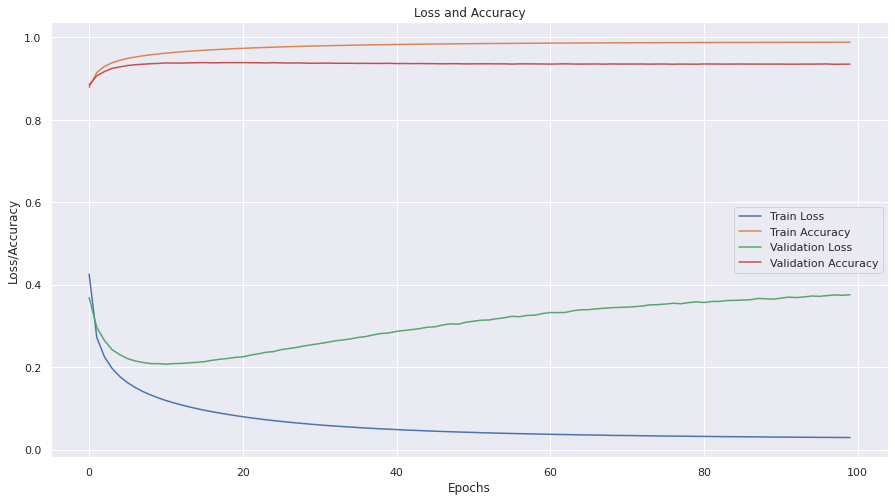

In [107]:
import pandas as pd

result = pd.DataFrame(model.history.history)
result.columns = ['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy']
result.plot(title='Loss and Accuracy', xlabel = 'Epochs', ylabel='Loss/Accuracy', figsize=(15,8));